In [1]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d

In [2]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interact_manual
import pandas as pd

In [3]:
from mip import Model, MINIMIZE, BINARY, MAXIMIZE
from mip import INTEGER, CBC, OptimizationStatus, CONTINUOUS

In [4]:
import numpy as np

In [6]:
def get_mip_solution_full(objective_mat, 
                     constraint_mat_lhs, 
                     constraint_mat_rhs,
                     ub_list, sense,
                     is_relaxed = True
                    ):
    
    assert constraint_mat_lhs.shape[1] == objective_mat.shape[0]
    assert constraint_mat_rhs.shape[0] == constraint_mat_lhs.shape[0]
    assert ub_list.shape[0] == constraint_mat_lhs.shape[1]

    num_vars = constraint_mat_lhs.shape[1]
    num_constraints = constraint_mat_lhs.shape[0]
    m = Model(sense=sense, solver_name=CBC)
    var_dict = {}
    var_type = INTEGER
    if is_relaxed:
        var_type=CONTINUOUS
    
    for i in range(num_vars):
        var_dict[i] = m.add_var(name=f"x{i}", lb=0, ub=ub_list[i], 
                                var_type=var_type)

    for j in range(num_constraints):
        lhs_mat = constraint_mat_lhs[j]
        m += np.dot(lhs_mat, np.array(list(var_dict.values()))) <= constraint_mat_rhs[j]
    
    m.objective = np.dot(objective_mat, np.array(list(var_dict.values())))
    
    m.max_gap = 0.05
    status = m.optimize(max_seconds=300)
    sol_dict = {}
    objective = 0
    if status == OptimizationStatus.OPTIMAL:
        print('optimal solution cost {} found'.format(m.objective_value))
    elif status == OptimizationStatus.FEASIBLE:
        print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
    elif status == OptimizationStatus.NO_SOLUTION_FOUND:
        print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
        for v in m.vars:
            sol_dict[v.name] = None
        return sol_dict, objective
        

    
    if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
        print('solution:')
        objective = m.objective_value
        for v in m.vars:
            if abs(v.x) >= 0:
                sol_dict[v.name] = v.x
                print('{} : {}'.format(v.name, v.x))
                
                
    return sol_dict, objective
        

## Problem Statement

Maximise 3 x1 + 5 x2

Constraints

- x1 <= 4
- 2 x2 <= 12
- 3 x1 + 2 x2 <= 18

x1 and x2 are integers

In [7]:
objective_mat = np.array([3,5])
constraint_mat_lhs =  np.array([[1,0], [0,2], [3,2]])
constraint_mat_rhs = np.array([4, 12, 18])
ub_list = np.array([20, 20])

In [8]:
k = get_mip_solution_full(objective_mat, 
                     constraint_mat_lhs, 
                     constraint_mat_rhs,
                     ub_list,
                 MAXIMIZE,
                     is_relaxed=True
                    )

optimal solution cost 36.0 found
solution:
x0 : 2.0
x1 : 6.0


In [9]:
objective_mat = np.array([5.5,2.1])
constraint_mat_lhs =  np.array([[-1,1], [8,2]])
constraint_mat_rhs = np.array([2, 17])
ub_list = np.array([20, 20])

In [11]:
# P0
k, o = get_mip_solution_full(objective_mat, 
                     constraint_mat_lhs, 
                     constraint_mat_rhs,
                     ub_list,
                 MAXIMIZE,
                    is_relaxed=True
                    )

optimal solution cost 14.08 found
solution:
x0 : 1.3
x1 : 3.3


In [12]:
def get_new_constr_mat(branching_var, sol_dict, constraint_mat_lhs, constraint_mat_rhs):
    print(f'branching on var {f"x{branching_var}"}')
    new_constr_le = np.zeros((1, constraint_mat_lhs.shape[1]))
    new_constr_ge = np.zeros((1, constraint_mat_lhs.shape[1]))
    new_constr_le[0,branching_var] = 1
    new_constr_ge[0,branching_var] = -1
    constraint_mat_rhs_ge = np.append(constraint_mat_rhs, -1*(int(sol_dict[f"x{branching_var}"])+1))
    constraint_mat_rhs_le = np.append(constraint_mat_rhs, int(sol_dict[f"x{branching_var}"]))
    constraint_mat_lhs_ge = np.append(constraint_mat_lhs, new_constr_ge, axis=0)
    constraint_mat_lhs_le = np.append(constraint_mat_lhs, new_constr_le, axis=0)
    
    constraint_mat_rhs_all = np.append(constraint_mat_rhs, -1*(int(sol_dict[f"x{branching_var}"])+1))
    constraint_mat_rhs_all = np.append(constraint_mat_rhs_all, int(sol_dict[f"x{branching_var}"]))
    constraint_mat_lhs_all = np.append(constraint_mat_lhs, new_constr_ge, axis=0)
    constraint_mat_lhs_all = np.append(constraint_mat_lhs_all, new_constr_le, axis=0)
    
    return constraint_mat_rhs_ge, constraint_mat_lhs_ge, constraint_mat_rhs_le, constraint_mat_lhs_le, constraint_mat_rhs_all, constraint_mat_lhs_all

In [21]:
def get_child_node_solutions(branching_var, sol_dict, objective_mat, constraint_mat_lhs, constraint_mat_rhs, 
                    ub_list, sense, prefix):
    c_mat_rhs_ge, c_mat_lhs_ge, c_mat_rhs_le, c_mat_lhs_le, c_mat_rhs_all, c_mat_lhs_all = get_new_constr_mat(branching_var, sol_dict, 
                                                                                constraint_mat_lhs, 
                                                                                constraint_mat_rhs)

    sol_dict_ge, obj_ge = get_mip_solution_full(objective_mat, c_mat_lhs_ge, c_mat_rhs_ge, ub_list, sense)
    sol_dict_le, obj_le = get_mip_solution_full(objective_mat, c_mat_lhs_le, c_mat_rhs_le, ub_list, sense)
    
    print(f"ge solution: {sol_dict_ge}, {obj_ge}")
    print(f"le solution: {sol_dict_le}, {obj_le}")
    dataset_mat = {f"{prefix}_rhs_ge": c_mat_rhs_ge, f"{prefix}_lhs_ge": c_mat_lhs_ge,
                   f"{prefix}_rhs_le": c_mat_rhs_le, f"{prefix}_lhs_le": c_mat_lhs_le,
                   f"{prefix}_rhs_all": c_mat_rhs_all, f"{prefix}_lhs_all": c_mat_lhs_all,
                   
                  }
    return sol_dict_ge, obj_ge, sol_dict_le, obj_le, dataset_mat

## Visualise constraint matrix

In [22]:
num_points = 49
x1_ub = 10
x2_ub = 10

In [23]:
x1_range = np.linspace(0, x1_ub, num_points)
x2_range = np.linspace(0, x2_ub, num_points)

In [24]:
x1_range.shape

(49,)

In [25]:
def plot_constraints_from_matrix(c_mat_lhs, c_mat_rhs, x1_range):
    constraint_ranges = {}
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    for const_id in range(c_mat_lhs.shape[0]):
        constraint_ranges[const_id] = {}
        const_lhs = c_mat_lhs[const_id]
        const_rhs = c_mat_rhs[const_id]

        if const_lhs[0] == 0:
            multiplier = 1
            if const_lhs[1] < 0:
                multiplier = -1
            constraint_ranges[const_id]["x"] = x1_range*const_lhs[1]*multiplier
            constraint_ranges[const_id]["y"] = [const_rhs*multiplier]*x1_range.shape[0]
            ax.plot(constraint_ranges[const_id]["x"], constraint_ranges[const_id]["y"], label=f'{const_lhs[1]}y <= {const_rhs}')
            continue
        
        if const_lhs[1] == 0:
            multiplier = 1
            if const_lhs[0] < 0:
                multiplier = -1
            constraint_ranges[const_id]["x"] = [const_rhs*multiplier]*x1_range.shape[0]
            constraint_ranges[const_id]["y"] = x1_range*const_lhs[0] * multiplier
            
            ax.plot(constraint_ranges[const_id]["x"], constraint_ranges[const_id]["y"], label=f'{const_lhs[0]}x <= {const_rhs}')
            continue
        
        constraint_ranges[const_id]["x"] = x1_range
        constraint_ranges[const_id]["y"] = (-1*const_lhs[0]*x1_range + const_rhs)/const_lhs[1]
        ax.plot(constraint_ranges[const_id]["x"], constraint_ranges[const_id]["y"], 
                label=f'{const_lhs[0]}x + {const_lhs[1]}y <= {const_rhs}')
    
    
    plt.xlim(-0.01, 10)
    plt.ylim(-0.01, 10)
    plt.legend()
    plt.show()
    return constraint_ranges

In [26]:
constraint_mat_lhs

array([[-1,  1],
       [ 8,  2]])

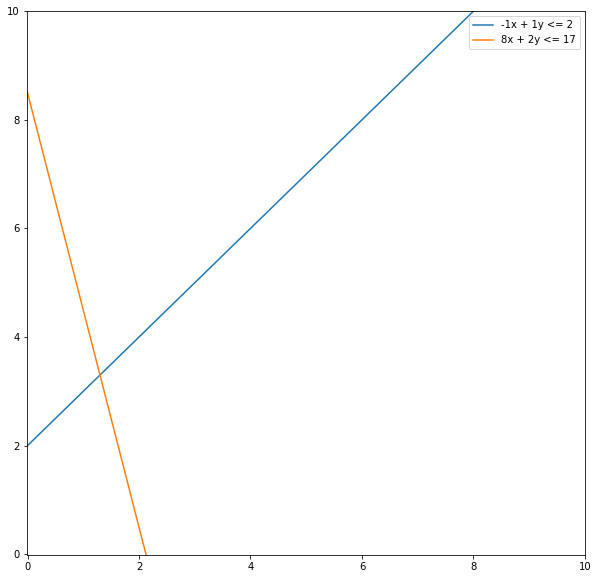

In [27]:
a = plot_constraints_from_matrix(constraint_mat_lhs, constraint_mat_rhs, x1_range)

In [28]:
# P1
objective_mat = np.array([5.5,2.1])
constraint_mat_lhs =  np.array([[-1,1], [8,2]])
constraint_mat_rhs = np.array([2, 17])
ub_list = np.array([20, 20])

k_1, o_1, k_2, o_2, data_p1 = get_child_node_solutions(0, k, objective_mat, 
                     constraint_mat_lhs, 
                     constraint_mat_rhs,
                     ub_list,
                 MAXIMIZE, "p1"
                    )

branching on var x0
optimal solution cost 12.05 found
solution:
x0 : 2.0
x1 : 0.5
optimal solution cost 11.8 found
solution:
x0 : 1.0
x1 : 3.0
ge solution: {'x0': 2.0, 'x1': 0.5}, 12.05
le solution: {'x0': 1.0, 'x1': 3.0}, 11.8


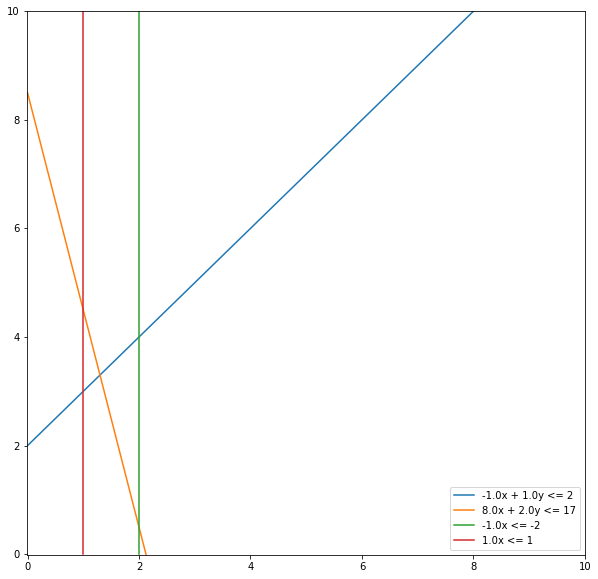

{0: {'x': array([ 0.        ,  0.20833333,  0.41666667,  0.625     ,  0.83333333,
          1.04166667,  1.25      ,  1.45833333,  1.66666667,  1.875     ,
          2.08333333,  2.29166667,  2.5       ,  2.70833333,  2.91666667,
          3.125     ,  3.33333333,  3.54166667,  3.75      ,  3.95833333,
          4.16666667,  4.375     ,  4.58333333,  4.79166667,  5.        ,
          5.20833333,  5.41666667,  5.625     ,  5.83333333,  6.04166667,
          6.25      ,  6.45833333,  6.66666667,  6.875     ,  7.08333333,
          7.29166667,  7.5       ,  7.70833333,  7.91666667,  8.125     ,
          8.33333333,  8.54166667,  8.75      ,  8.95833333,  9.16666667,
          9.375     ,  9.58333333,  9.79166667, 10.        ]),
  'y': array([ 2.        ,  2.20833333,  2.41666667,  2.625     ,  2.83333333,
          3.04166667,  3.25      ,  3.45833333,  3.66666667,  3.875     ,
          4.08333333,  4.29166667,  4.5       ,  4.70833333,  4.91666667,
          5.125     ,  5.33333333,  

In [29]:
plot_constraints_from_matrix(data_p1["p1_lhs_all"], data_p1["p1_rhs_all"], x1_range)

In [30]:
data_p1["p1_rhs_ge"], data_p1["p1_lhs_ge"]

(array([ 2, 17, -2]),
 array([[-1.,  1.],
        [ 8.,  2.],
        [-1.,  0.]]))

In [31]:
data_p1["p1_rhs_le"], data_p1["p1_lhs_le"]

(array([ 2, 17,  1]),
 array([[-1.,  1.],
        [ 8.,  2.],
        [ 1.,  0.]]))

In [32]:
k_1

{'x0': 2.0, 'x1': 0.5}

In [33]:
# P2

k_3, o_3, k_4, o_4, data_p2 = get_child_node_solutions(1, k_1, objective_mat, 
                     data_p1["p1_lhs_ge"], 
                     data_p1["p1_rhs_ge"], 
                     ub_list,
                 MAXIMIZE, "p2"
                    )

branching on var x1
optimal solution cost 11.6875 found
solution:
x0 : 2.125
x1 : 0.0
ge solution: {}, 0
le solution: {'x0': 2.125, 'x1': 0.0}, 11.6875


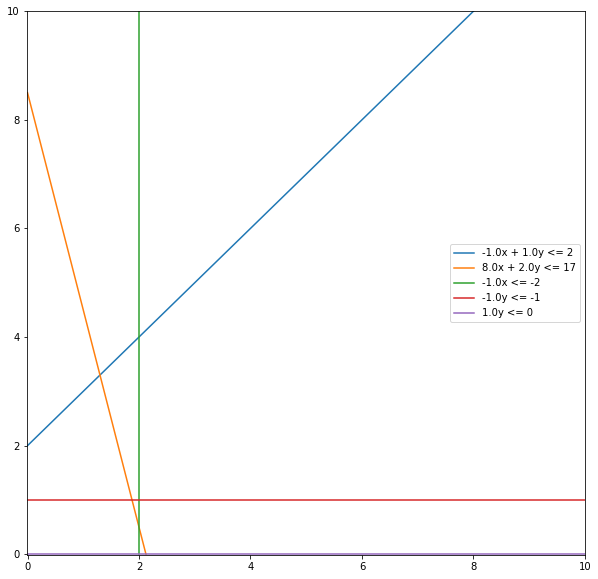

{0: {'x': array([ 0.        ,  0.20833333,  0.41666667,  0.625     ,  0.83333333,
          1.04166667,  1.25      ,  1.45833333,  1.66666667,  1.875     ,
          2.08333333,  2.29166667,  2.5       ,  2.70833333,  2.91666667,
          3.125     ,  3.33333333,  3.54166667,  3.75      ,  3.95833333,
          4.16666667,  4.375     ,  4.58333333,  4.79166667,  5.        ,
          5.20833333,  5.41666667,  5.625     ,  5.83333333,  6.04166667,
          6.25      ,  6.45833333,  6.66666667,  6.875     ,  7.08333333,
          7.29166667,  7.5       ,  7.70833333,  7.91666667,  8.125     ,
          8.33333333,  8.54166667,  8.75      ,  8.95833333,  9.16666667,
          9.375     ,  9.58333333,  9.79166667, 10.        ]),
  'y': array([ 2.        ,  2.20833333,  2.41666667,  2.625     ,  2.83333333,
          3.04166667,  3.25      ,  3.45833333,  3.66666667,  3.875     ,
          4.08333333,  4.29166667,  4.5       ,  4.70833333,  4.91666667,
          5.125     ,  5.33333333,  

In [34]:
plot_constraints_from_matrix(data_p2["p2_lhs_all"], data_p2["p2_rhs_all"], x1_range)

In [36]:
# P0
k, o = get_mip_solution_full(objective_mat, 
                     constraint_mat_lhs, 
                     constraint_mat_rhs,
                     ub_list,
                 MAXIMIZE,
                    )

optimal solution cost 14.08 found
solution:
x0 : 1.3
x1 : 3.3


In [37]:
# P1
objective_mat = np.array([5.5,2.1])
constraint_mat_lhs =  np.array([[-1,1], [8,2]])
constraint_mat_rhs = np.array([2, 17])
ub_list = np.array([20, 20])

k_1, o_1, k_2, o_2, data_p1 = get_child_node_solutions(1, k, objective_mat, 
                     constraint_mat_lhs, 
                     constraint_mat_rhs,
                     ub_list,
                 MAXIMIZE, "p1"
                    )

branching on var x1
optimal solution cost 13.8625 found
solution:
x0 : 1.375
x1 : 3.0
ge solution: {}, 0
le solution: {'x0': 1.375, 'x1': 3.0}, 13.8625


In [38]:
# P0
k, o = get_mip_solution_full(objective_mat, 
                     constraint_mat_lhs, 
                     constraint_mat_rhs,
                     ub_list,
                 MAXIMIZE,
                        is_relaxed=False
                    )

optimal solution cost 11.8 found
solution:
x0 : 1.0
x1 : 3.0


In [39]:
a = np.array([1.0, 2.1])

In [40]:
np.where((a.astype(int)==a)==False)

(array([1]),)

In [41]:
def get_non_int_vars(sol_array):
    return np.where((sol_array.astype(int)==sol_array)==False)[0]
    

In [42]:
np.zeros((1, constraint_mat_lhs.shape[1]))[0,1]=1

In [43]:
def get_new_constr_mat(branching_var, sol_dict, constraint_mat_lhs, constraint_mat_rhs):
    new_constr = np.zeros((1, constraint_mat_lhs.shape[1]))
    new_constr_le[0,branching_var] = 1
    new_constr_ge[0,branching_var] = -1
    constraint_mat_rhs_ge = np.append(constraint_mat_rhs, int(sol_dict[f"x{branching_var}"])+1)
    constraint_mat_rhs_le = np.append(constraint_mat_rhs, int(sol_dict[f"x{branching_var}"]))
    constraint_mat_lhs_ge = np.append(constraint_mat_lhs, new_constr_ge, axis=0)
    constraint_mat_lhs_le = np.append(constraint_mat_lhs, new_constr_le, axis=0)
    
    return constraint_mat_rhs_ge, constraint_mat_lhs_ge, constraint_mat_rhs_le, constraint_mat_lhs_le

In [52]:
# TODO: Fix this recursion
def get_mip_solution(objective_mat, 
                     constraint_mat_lhs, 
                     constraint_mat_rhs,
                     ub_list, sense):
    
    sol_dict, obj = get_mip_solution_full(objective_mat, 
                     constraint_mat_lhs, 
                     constraint_mat_rhs,
                     ub_list, MAXIMIZE)
    
    branching_vars = get_non_int_vars(np.array(list(sol_dict.values())))
    print(branching_vars)
    if len(branching_vars) ==0 :
        return sol_dict, obj
    
    
    return sol_dict    

## Visualisation

In [53]:
num_points = 49
x1_ub = 10
x2_ub = 10

In [54]:
x1_range = np.linspace(0, x1_ub, num_points)
x2_range = np.linspace(0, x2_ub, num_points)

In [55]:
constr_1 = np.array([4]*len(x1_range))
constr_2 = np.array([6]*len(x1_range))

constr_3 = -1.5*x1_range  +9

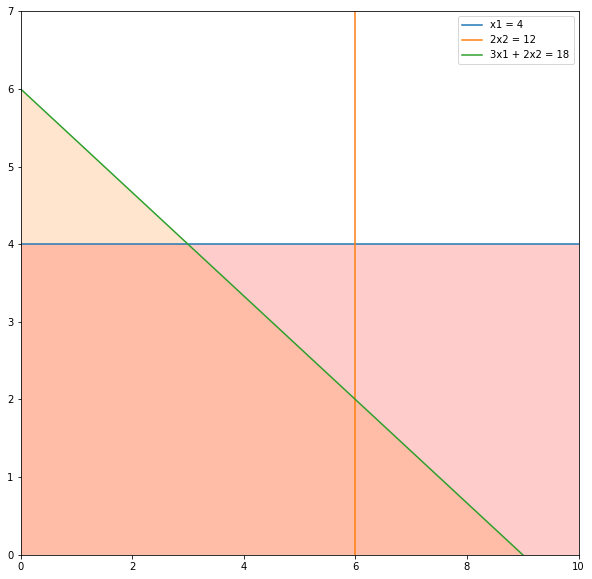

In [56]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.plot(x1_range, constr_1, label='x1 = 4')
ax.fill_between(x1_range, 0, constr_1, facecolor='red', alpha=0.2)
ax.plot(constr_2, x1_range, label='2x2 = 12')
ax.fill_between(0, constr_2, x1_range, alpha=0.2)
ax.plot(constr_3, x1_range, label='3x1 + 2x2 = 18')
ax.fill_between(constr_3, 0, x1_range, alpha=0.2)
plt.xlim(0, 10)
plt.ylim(0, 7)
plt.legend()
plt.show()

In [57]:
def get_constr_1(constr_1_val):
    return x1_range, constr_1_val*np.ones(shape=x1_range.shape)


In [58]:
def get_constr_2(constr_2_val):
    return constr_2_val*np.ones(shape=x1_range.shape), x1_range


In [59]:
def get_constr_3(coeff, intercept):
    return coeff*x1_range+intercept, x1_range


## Search Space Visualisation

In [60]:
%matplotlib inline
@interact
def plot_search_space(constr_1_val=(0, 8, 0.5), 
                      constr_2_val = (0, 12, 0.5), 
                      coeff = (-5, -1, 0.5),
                      intercept=(1, 18, 0.5),
                      unbound_1 = [False, True],
                      unbound_3 = [False, True]
                     ):
    
    fill_1 = 0
    symbol_1 = "<="
    symbol_3 = "<="
    fill_3 = 0

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    
    x, y = get_constr_1(constr_1_val)
    if unbound_1:
        fill_1=10
        symbol_1 = ">="
    ax.plot(x, y, label=f'x1 {symbol_1} {constr_1_val}')
    ax.fill_between(x, fill_1, y,   facecolor='red', alpha=0.2)
    
    x, y = get_constr_2(constr_2_val)
    ax.plot(x, y, label=f'2x2 <= {2*constr_2_val}')
#     ax.fill_between(0, x, y, alpha=0.2)
    points = pd.DataFrame([(i,j) for i in range(int(constr_2_val)+1) for j in range(int(constr_1_val) + 1)], columns=["x", "y"])

    if unbound_3:
        fill_3 = 10
        symbol_3 = ">="
    x, y = get_constr_3(coeff, intercept)
    ax.plot(x, y, label=f'x2 {symbol_3} {coeff} x1 + {intercept}')
    ax.fill_between( x, fill_3, y, alpha=0.2)
    points = points.loc[-points['y']*coeff + points['x'] <= intercept]
    plt.scatter(points['x'], points['y'], color='r')
    plt.xlim(0, 10)
    plt.ylim(0, 7)
    plt.legend(fontsize='large')
    plt.show()
    print(constr_1_val)

interactive(children=(FloatSlider(value=4.0, description='constr_1_val', max=8.0, step=0.5), FloatSlider(value…

In [61]:
def get_objective(x1_coeff, x2_coeff, obj_intercept):
    return -(x1_coeff/x2_coeff)*x1_range + obj_intercept/x2_coeff, x1_range


In [62]:
def get_perpendicular(x1_coeff, x2_coeff):
    return (x2_coeff/x1_coeff)*x1_range, x1_range


In [63]:
%matplotlib inline
@interact
def plot_solution_space(c1_val=(0, 8, 0.5), 
                        c2_val = (0, 12, 0.5), 
                        c3_coeff = (-5, -1, 0.5),
                        c3_incpt=(1, 18, 0.5),
                        x1_coeff = (0, 6, 0.5),
                        x2_coeff = (0, 10, 0.5), 
                        obj_incpt= (10, 70, 1),
#                         plot_perpendicular=[False, True],
                        plot_feasible=[False, True]
                       ):
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    
    x, y = get_constr_1(c1_val)
    ax.plot(x, y, label=f'x1 = {c1_val}')
    
    x, y = get_constr_2(c2_val)
    ax.plot(x, y, label=f'2x2 = {2*c2_val}')
    
    x, y = get_constr_3(c3_coeff, c3_incpt)
    ax.plot(x, y, label=f'x2 = {c3_coeff} x1 + {c3_incpt}')
    
    x1, y1 = get_objective(x1_coeff, x2_coeff, obj_incpt)

    condition = (x1<=x+0.2)&(y1<=y+0.2)&(x1<=c2_val+0.1)&(y1<=c1_val+0.1)
    if plot_feasible:
        x1 = x1[condition]
        y1 = y1[condition]
    ax.plot(x1, y1, label=f'{obj_incpt} = {x1_coeff} x1 + {x2_coeff} x2')
#     if plot_perpendicular:
#         x, y = get_perpendicular(x1_coeff, x2_coeff)
#         ax.plot(x, y, label=f'perpendicular')
    obj = obj_incpt
    if len(x1)==0:
        obj = 0
    print('objective : ', obj, 
          [((-x1_coeff/x2_coeff)*i + obj_incpt/x2_coeff, i) for i in y1]
         )
    plt.xlim(0, 10)
    plt.ylim(0, 7)
    plt.legend()
    plt.show()

    

interactive(children=(FloatSlider(value=4.0, description='c1_val', max=8.0, step=0.5), FloatSlider(value=6.0, …

## Objective Space Visualisation

In [64]:
def objective(x1, x2):
    return 3*x1 +5*x2

In [65]:
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = objective(X1, X2)

/Users/chatty/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  after removing the cwd from sys.path.


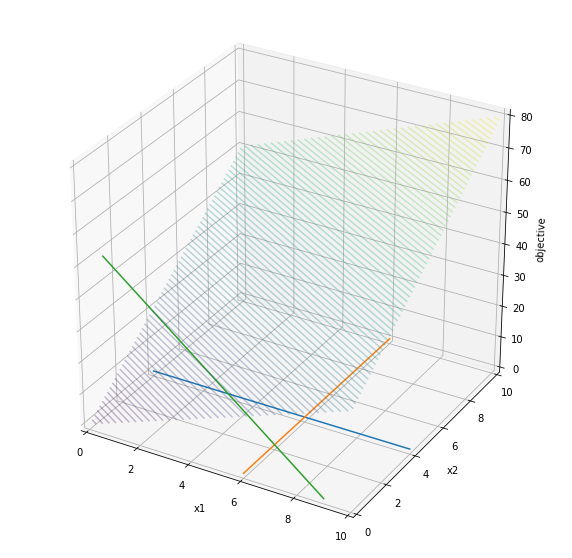

In [66]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.contour3D(X1, X2, Z, 100, cmap='viridis', edgecolor='none', alpha=0.3)

ax.plot(x1_range, constr_1, zs=0, zdir='z', label='curve in (x,y)')
ax.plot(constr_2, x1_range, zs=0, zdir='z', label='2x2 = 6')
ax.plot(constr_3, x1_range, zs=0, zdir='z', label='3x1 + 2x2 = 18')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('objective')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
plt.show()

In [67]:
condition = (x1_range <=6) &(x2_range<=4)
X1_filt, X2_filt = np.meshgrid(x1_range[x1_range <=6], x2_range[x2_range<=4])
Z_filt = objective(X1_filt, X2_filt)

/Users/chatty/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  after removing the cwd from sys.path.


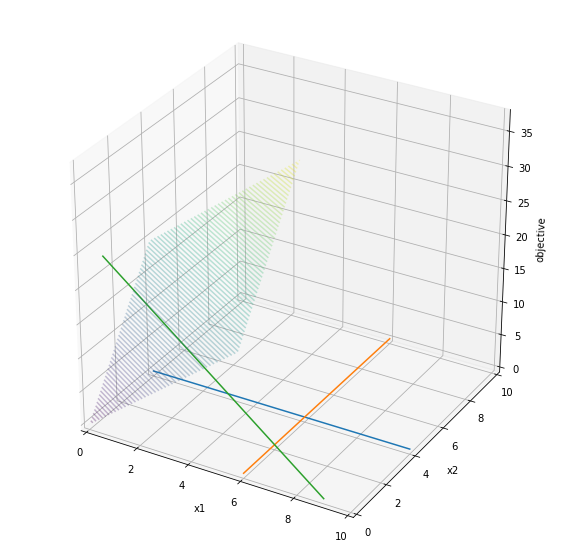

In [68]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.contour3D(X1_filt, X2_filt, Z_filt, 100, cmap='viridis', edgecolor='none', alpha=0.3)

ax.plot(x1_range, constr_1, zs=0, zdir='z', label='curve in (x,y)')
ax.plot(constr_2, x1_range, zs=0, zdir='z', label='2x2 = 6')
ax.plot(constr_3, x1_range, zs=0, zdir='z', label='3x1 + 2x2 = 18')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('objective')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
plt.show()